In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv("./data/market/Ulhasnagar.Rice.csv")
df['Price Date'] = pd.to_datetime(df['Price Date'], format='%d %b %Y').dt.strftime('%Y-%m-%d')
df.drop(['Min Price (Rs./Quintal)','Max Price (Rs./Quintal)',], axis=1, inplace = True)
df.rename(columns={'Modal Price (Rs./Quintal)':'Price', 'Price Date': 'Date'}, inplace = True)
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)
df.index = pd.to_datetime(df.index)
df

,Price
Date,
2015-12-08,4500
2015-12-16,3850
2016-01-08,3000
2016-02-15,2500
2016-02-18,2900
...,...
2024-02-22,4500
2024-02-27,4000
2024-02-28,4500


In [4]:

df = df.resample('D').first()

df['Price'].interpolate(method='pchip', inplace=True)
df

C:\Users\jatin\AppData\Local\Temp\ipykernel_9292\3950296218.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].interpolate(method='pchip', inplace=True)


,Price
Date,
2015-12-08,4500.000000
2015-12-09,4407.025939
2015-12-10,4314.449083
2015-12-11,4223.745694
2015-12-12,4136.392037
...,...
2024-02-26,4052.000000
2024-02-27,4000.000000
2024-02-28,4500.000000


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,3007.0,3601.018631,615.389123,2000.0,3100.0,3500.0,4000.0,8500.0


In [6]:
print(df['Price'].min())

2000.0


<Axes: xlabel='Date'>

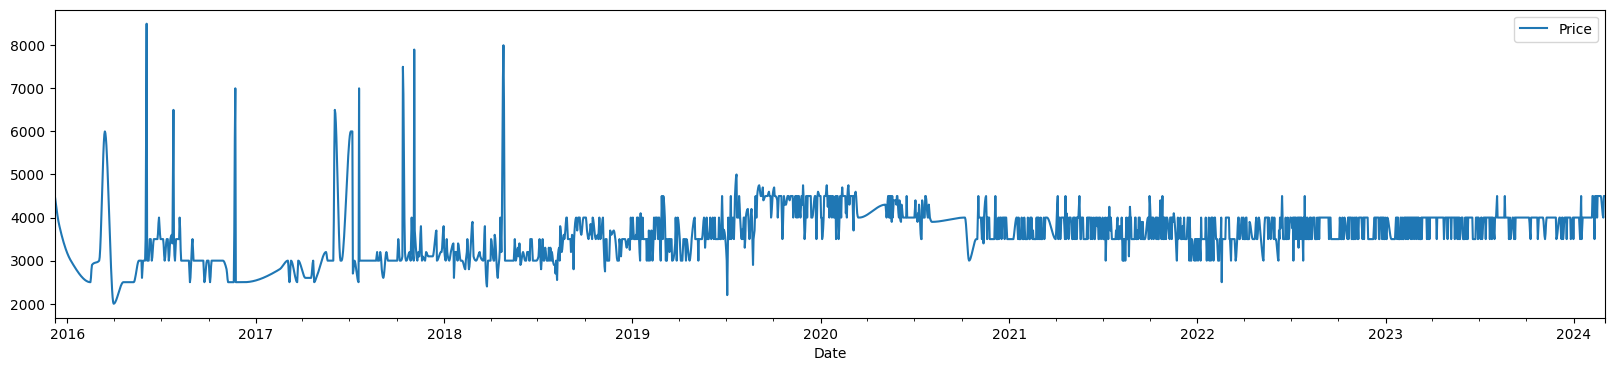

In [7]:
df.plot(figsize=(20, 4))

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
result = seasonal_decompose(df, model="multiplicative")

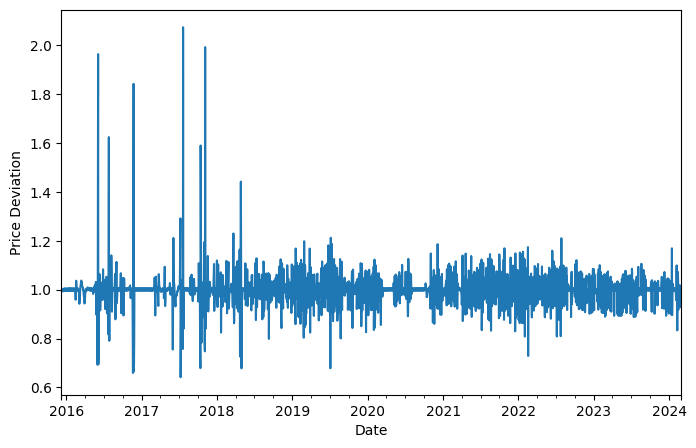

In [10]:
result.resid.plot(figsize=(8, 5))
plt.ylabel("Price Deviation")
plt.show()

In [11]:
PREDICTION_DAYS = 28

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [14]:
sequence_length = 56

In [15]:
X, y = [], []

sequences = []

for i in range(len(df) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[(i + sequence_length)][0])

X = np.array(X)
y = np.array(y)

In [16]:
X.shape, y.shape

((2951, 56, 1), (2951,))

In [17]:
split = int(0.8 * len(X))

In [18]:
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [19]:
X_train.shape
y_train.shape

(2360,)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=64, return_sequences=True, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=False),
        Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model.fit(X_train, y_train, batch_size=28, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
85/85 [==============================] - 3s 32ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 2/50
85/85 [==============================] - 3s 34ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 3/50
85/85 [==============================] - 3s 31ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 4/50
85/85 [==============================] - 3s 32ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/50
85/85 [==============================] - 3s 32ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 6/50
85/85 [==============================] - 3s 31ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 7/50
85/85 [==============================] - 3s 36ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 8/50
85/85 [==============================] - 3s 39ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 9/50
85/85 [==============================] - 3s 32ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 10/50
85/85 [==============================] - 3s 31ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 11/

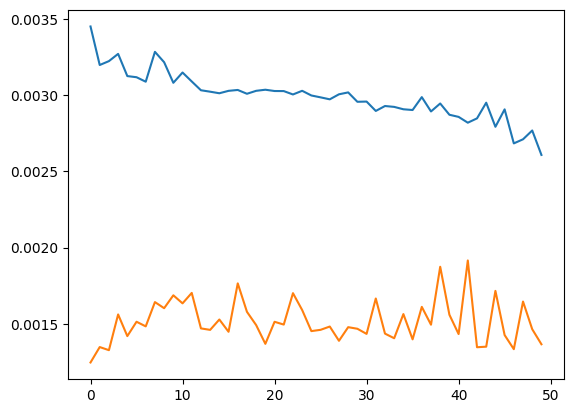

In [34]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [35]:
from joblib import dump, load

In [36]:
x_test = scaled_data[-sequence_length:]
x_test = np.array([x_test])

In [37]:
x_test.shape

(1, 56, 1)

In [38]:
predictions = model.predict(X)

93/93 [==============================] - 1s 13ms/step


In [39]:
predictions = predictions.reshape(-1,1)
predictions = scaler.inverse_transform(predictions).flatten()

In [40]:
from datetime import timedelta

In [41]:
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 29)]

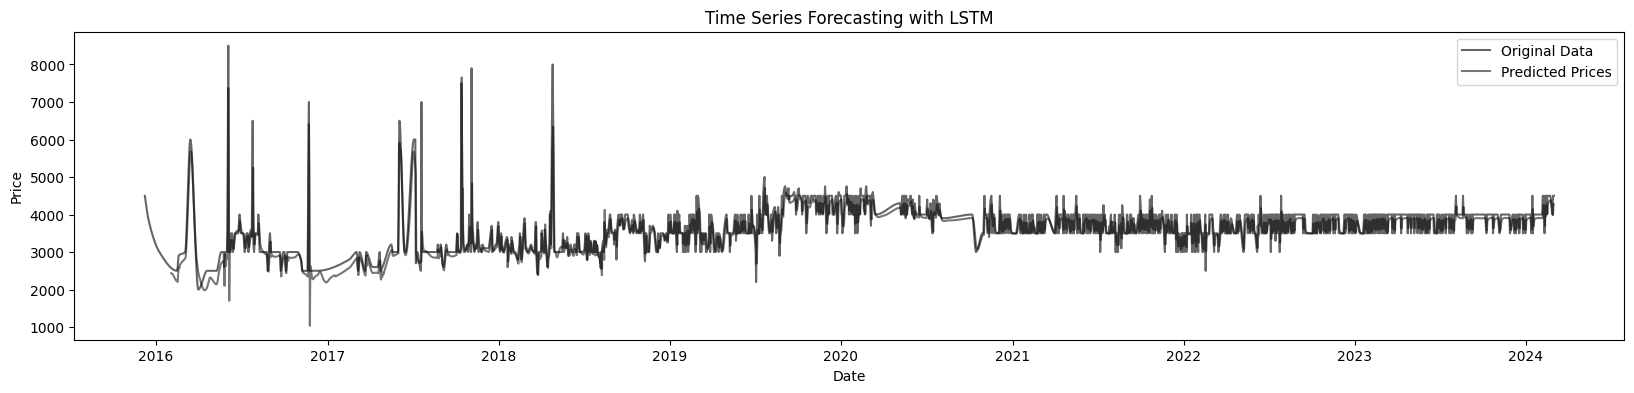

In [42]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Price'], label='Original Data', c="#666666")
plt.plot(df.index[sequence_length:], predictions, label='Predicted Prices', c="#00000088")
plt.title('Time Series Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(
    mean_absolute_error(predictions, df["Price"][sequence_length:]),
    mean_squared_error(predictions, df["Price"][sequence_length:], squared=False),
)

C:\Users\jatin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(205.40110216636023, 318.6372364857488)